# Davide Scassola, Numerical Analysis project

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
arc = load('mnist.npz')

x_train = arc['arr_0']
y_train = arc['arr_1']
x_test  = arc['arr_2']
y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


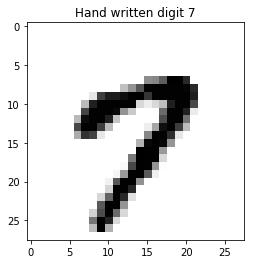

In [5]:
# Show image number 15, and write in the title what digit it should correspond to
N=15
imshow(x_train[N], cmap='gray_r')
_ = title('Hand written digit '+str(y_train[N]))

In [6]:
def classify(z, dist):
    all_distances = array([dist(x, z) for x in x_train])
    digit = y_train[argmin(all_distances)]
    return digit

General guidelines:

- Time all functions you construct, and try to make them run as fast as possible by precomputing anything that can be precomputed
- Extra points are gained if you reduce the complexity of the given algorithms in any possible way, for example by exploiting linearity, etc.
- If something takes too long to execute, make sure you time it on a smaller set of input data, and give estimates of how long it would take to run the full thing (without actually running it). Plot only the results you manage to run on your PC.


# Assignment 1

Implement the following distance functions

- d_infty $$ d_{\infty}(a,b) := \max_{i,j} |b_{ij}-a_{ij}|$$
- d_one $$ d_1(a,b) := \sum_{i,j} |b_{ij}-a_{ij}|$$
- d_two $$ d_2(a,b) := \sqrt{\sum_{i,j} |b_{ij}-a_{ij}|^2}$$

that take two `(28,28)` images in input, and return a non-negative number.

In [8]:
def d_infty(a,b):
    return norm((a-b).ravel(), inf)

def d_one(a,b):
    return norm((a-b).ravel(), 1)

def d_two(a,b):
    return norm((a-b).ravel(), 2)

# Assignment 2

Write a function that, given a number `N`, and a distance function `dist`, computes the distance matrix D of shape `(N,N)` between the first `N` entries of `x_train`:

```
D[i,j] = dist(x_train[i], x_train[j])
```

performing the **minimum** number of operations (i.e., avoid computing a distance if it has already been computed before, i.e., keep in mind that dist(a,b) = dist(b,a)).

In [9]:
def distance_matrix(N,dist):
    D = zeros((N,N))
    for i in range(N):
        """it's not necessary to compute the diagonal, but it's cheap and
            can be useful for checking the correctness"""
        for j in range(i+1): 
            D[i,j] = D[j,i] = dist(x_train[i],x_train[j])
    return D


# Assignment 3

Compute and plot the three distance matrices

- Dinfty
- D1
- D2

for the first 100 images of the training set, using the function `imshow` applied to the three matrices

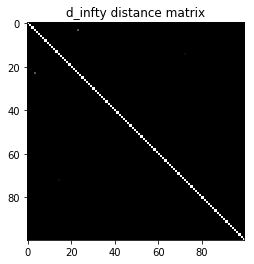

In [7]:
imshow(distance_matrix(100,d_infty), cmap='gray_r')
_ = title('d_infty distance matrix')

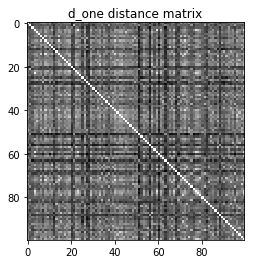

In [8]:
imshow(distance_matrix(100,d_one), cmap='gray_r')
_ = title('d_one distance matrix')

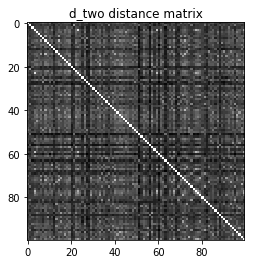

In [9]:
imshow(distance_matrix(100,d_two), cmap='gray_r')
_ = title('d_two distance matrix')

# Assignment 4

Using only a distance matrix, apply the algorithm described above and compute the efficency of the algorithm, i.e., write a function that:

Given a distance matrix with shape `(N,N)`, constructed on the first `N` samples of the `x_train` set, count the number of failures of the **leave one out** strategy, i.e., 

- set `error_counter` to zero

- for every line `i` of the matrix:

    - find the index `j` (different from `i`) for which `D[i,k] >= D[i,j]` for all `k` different from `i` and `j`.

    - if `y_train[j]` is different from `y_train[i]`, increment by one `error_counter`

- return the error: error_counter/N

- apply the function above to the 3 different distance matrices you computed before

In [35]:
def performance_evaluator(N, dist_mat):
    """I can input a bigger matrix"""
    D = dist_mat[0:N,0:N] 
    error_counter = 0
    D[0,0] = D[0,1]+42 # so the first doesn't consider itself
    for i in range(N):
        l = D[i]
        l[i] = l[0]+33 # so it doesn't consider itself
        closer_one = argmin(l)
        if(y_train[i] != y_train[closer_one]):
            error_counter = error_counter + 1
        l[i]=0 # correcting the matrix
             
    return error_counter/N

# Assignment 5

Run the algorithm implemented above for N=100,200,400,800,1600 on the three different distances, and plot the three error rate as a function of N (i.e., compute the distance matrix, and compute the efficiency associated to the distance matrix).

You should get an error like:
```
[[ 0.58      0.17      0.17    ]
 [ 0.52      0.145     0.135   ]
 [ 0.4425    0.15      0.135   ]
 [ 0.4       0.145     0.12875 ]
 [ 0.369375  0.1025    0.09375 ]]
```
where each column represents a different norm.

In [36]:
sizes = [100,200,400,800,1600]
D_infty = distance_matrix(max(sizes),d_infty)
D_one = distance_matrix(max(sizes),d_one)
D_two = distance_matrix(max(sizes),d_two) 
errors = [[performance_evaluator(n,d) for d in [D_infty,D_one,D_two]] for n in sizes]
print("error rate for d_infty, d_one and d_two:")
errors

error rate for d_infty, d_one and d_two:


[[0.58, 0.17, 0.17],
 [0.52, 0.145, 0.135],
 [0.4425, 0.15, 0.135],
 [0.4, 0.145, 0.12875],
 [0.369375, 0.1025, 0.09375]]

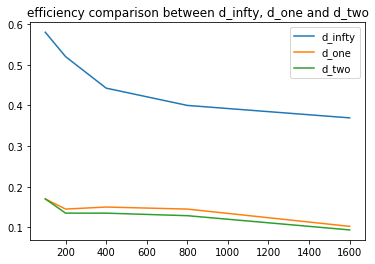

In [37]:
errors = array(errors)
for i in range(len(errors.T)):
    plot(sizes, errors.T[i])
    
_ = title('efficiency comparison between d_infty, d_one and d_two')
_ = legend(['d_infty','d_one','d_two'])

** In the next assignments, optional points are given if you manage to make the algorithm run faster, by pre-computing everything you can precompute in advance **

# Assignment 6

In principle, it should be possible to decrease the error by using a better norm. From the table above, it is clear that the L2 distance works better than the L1 distance, which works better than the Linfty distance.

However, *none of these distances exploit the fact that the image is a two-dimensional object*, and that there is information also in the **neighboring** information of the pixels. 

One way to exploit this, is to interpret the image as a continuous function with values between zero and one, defined on a square domain `\Omega=[0,27]x[0,27]`.

$$ f: \Omega \to R $$

- Implement a function that computes an approximation of the $H^1$ norm distance on the renormalized images. Given two images $f_1$ and $f_2$
    - Compute $$a = \frac{f_1}{\int_\Omega f_1}$$, $$b=\frac{f_2}{\int_\Omega f_2}$$
    - Define the $H^1$ distance as
    $$
    d_{H^1}(f_1,f_2) := \sqrt{\int_\Omega |\nabla(a-b)|^2+ (a-b)^2}
    $$
    using the algorithm you prefer (or the library you prefer) to compute the gradients and the integrals. Notice that $\nabla f = (\partial f/\partial x, \partial f/\partial y)$ is a vector valued function, and $|\nabla g|^2 := (\partial g/\partial x)^2 + (\partial g/\partial y)^2$

- Compute the distance matrix and the efficiency for this distance for N=100,200,400,800,1600


In [38]:
# I consider the image as a square of size 28x28, so dividing the side length by 28 
# we obtain intervals of 1 (h=1)

def image_integral(image):
    """it's just the sum, since the volume is the sum of "boxes" which base area is 1"""  
    return sum(image)

def gradient_norm(f):
    gr = numpy.gradient(f)
    return gr[0]**2 + gr[1]**2

def d_H1(f1,f2):
    a = f1/image_integral(f1)
    b = f2/image_integral(f2)
    
    diff = a-b
    
    """ I think I don't really need to compute the sqrt function if I just want to compare
        disances, since the square root it's a monotonous positive increasing function,
        so it doesn't change the ordering in the space. """
    return sqrt(image_integral(gradient_norm(diff) + diff**2))

In [39]:
"""It can be useful to do the following operations also in the test set"""
x = concatenate((x_train, x_test),axis = 0)

In [40]:
""" This distance requires more operations, so I try to exploit linearity 
    and do some precalculations on x."""


""" First, I generate the set of renormalized images. """

def generate_normalized_x():
    n = len(x)
    im_n = zeros(shape(x))
    for i in range(n):
        im_n[i] = x[i]/image_integral(x[i]) # normalizing   
    return im_n
        
normalized_x  =  generate_normalized_x()



""" Then, I generate the set of gradients of every normalized image.
    Exploiting linearity I can avoid the calculation of the gradient for each difference (a-b),
    so I have to compute just n gradients instead of n^2. """

# first index varies the image, the second one choose the x or y derivative
def generate_gradient_x():
    n = len(x)
    l = len(x[0])
    im_gr = zeros((n,2,l,l))
    for i in range(n):
        im_gr[i] = numpy.gradient(normalized_x[i]) # gradient
    return im_gr

gradient_x = generate_gradient_x()


""" Now I write a function that calculate the d_H1 distance between two images of the training set,
    the difference is that I compute two normalization and one gradient less than before.
    Note that for computing the distance between two images that don't necessarily belong to the training+test set,
    I still need the generic d_H1. """

def d_H1_cached(i,j):
    a = normalized_x[i]
    b = normalized_x[j]
    
    grXa = gradient_x[i][0]
    grYa = gradient_x[i][1]
    grXb = gradient_x[j][0]
    grYb = gradient_x[j][1]
    
    return sqrt(image_integral( (grXa-grXb)**2 + (grYa-grYb)**2 + (a-b)**2)) 


def distance_matrix_cached(N,dist_cached):
    D = zeros((N,N))
    for i in range(N):
        for j in range(i+1):
            D[i,j] = D[j,i] = dist_cached(i,j)
    return D


In [41]:
sizes = [100,200,400,800,1600]
%time D_H1 = distance_matrix_cached(max(sizes),d_H1_cached)
%time errors = [performance_evaluator(n,D_H1) for n in sizes]

print("error rate for d_H1")
errors

CPU times: user 18.7 s, sys: 3.99 ms, total: 18.7 s
Wall time: 18.7 s
CPU times: user 8.74 ms, sys: 0 ns, total: 8.74 ms
Wall time: 8.63 ms
error rate for d_H1


[0.23, 0.175, 0.145, 0.12125, 0.099375]

## Assignment 7

An even better improvement on the previous distance function is given by the following algorithm

- Given two images $f1$ and $f2$:
    - Compute $$a = \frac{f_1}{\int_\Omega f_1}$$, $$b=\frac{f_2}{\int_\Omega f_2}$$
    - Solve 
    $$
    -\Delta \phi = a - b \qquad \text{ in } \Omega
    $$
    $$
    \phi = 0 \text{ on } \partial\Omega
    $$
    - Define the *Monge Ampere* distance
    $$
    d_{MA}(f_1,f_2) = \int_\Omega (a+b)|\nabla \phi|^2
    $$

- Compute the distance matrix and the efficiency for this distance for N=100,200,400,800,1600

In [42]:
from scipy.sparse import diags
from scipy.sparse.linalg import splu
from scipy.sparse import csc_matrix

""" I built this Laplacian operator thinking about the order of the elements in Minst database's images,
    that is not the lexicographical one, but because of symmetry the result it's the same. """

def build_laplacian(N):
    L = diags([1,   1,-4,1,   1], [-N,   -1, 0, 1,    N], shape=(N*N, N*N)).toarray()
    for i in range(1,N):
        L[i*N,(i*N)-1] = 0
        L[(i*N)-1,i*N] = 0
    return L
   
    
""" Now I build a solver based on the LU decomposition of the Laplacian (with the minus sign) """

def build_poisson_equation_solver(N):
    LAP = -(1)*build_laplacian(N)
    LAP_csc = csc_matrix(LAP) # compact representation of sparse matrices
    return splu(LAP_csc) # lu decomposition for sparse matrices
    
    
""" In order to impose the boundary condition (= 0), I will apply the solver to the images
    without their boundary, so the dimension of the Laplacian to "invert" is (N-2)^2 x (N-2)^2. """

l = len(x_train[0]) - 2 
poisson_equation_solver = build_poisson_equation_solver(l)  
    
def solve_poisson_equation(image):
    L = len(image)
    reduced = image[1:-1,1:-1] # excluding the boundary
    l = L-2
    
    v = reduced.ravel()
    u = poisson_equation_solver.solve(v)
    
    u = reshape(u,(l,l))
    result = zeros((L,L))
    result[1:-1,1:-1]=u  # adding the 0 boundary
    return result


def d_MA(f1,f2):
    a = f1/image_integral(f1)
    b = f2/image_integral(f2)
    
    theta = solve_poisson_equation(a-b)
    return image_integral((a+b)*gradient_norm(theta))

In [43]:
""" As I did before, I try to exploit linearity and do some precalculations on x. """

def generate_poisson_equation_solution_x():
    n = len(normalized_x)
    im_n = zeros(shape(normalized_x))
    for i in range(n):
        im_n[i] = solve_poisson_equation(normalized_x[i])   
    return im_n

poisson_equation_solution_x = generate_poisson_equation_solution_x()


# first index varies the image, the second one choose the x or y derivative
def generate_gradient_poisson_equation_solution_x():
    n = len(poisson_equation_solution_x)
    l = len(poisson_equation_solution_x[0])
    im_gr = zeros((n,2,l,l))
    for i in range(n):
        im_gr[i] = numpy.gradient(poisson_equation_solution_x[i]) # gradient
    return im_gr

gradient_poisson_equation_solution_x = generate_gradient_poisson_equation_solution_x()



""" The most relevant improvement is given by the fact that I don't need to compute the solution
    of the poisson problem for every difference (a-b), since thanks to linearity I can just subtract the
    two precalculated solutions of the images. """
 
def d_MA_cached(i,j):
    a = normalized_x[i]
    b = normalized_x[j]
    
    grXa = gradient_poisson_equation_solution_x[i][0]
    grYa = gradient_poisson_equation_solution_x[i][1]
    grXb = gradient_poisson_equation_solution_x[j][0]
    grYb = gradient_poisson_equation_solution_x[j][1]
    
    return image_integral( ((grXa-grXb)**2 + (grYa-grYb)**2)*(a+b) )

In [44]:
sizes = [100,200,400,800,1600]
%time D_MA = distance_matrix_cached(max(sizes),d_MA_cached)
%time errors = [performance_evaluator(n,D_MA) for n in sizes]

print("error rate for d_MA")
errors

CPU times: user 16.6 s, sys: 24 ms, total: 16.6 s
Wall time: 16.6 s
CPU times: user 9.84 ms, sys: 25 µs, total: 9.86 ms
Wall time: 9.64 ms
error rate for d_MA


[0.24, 0.2, 0.145, 0.12875, 0.12125]

## Assigment 8 (optional for DSSC, PhD and LM, Mandatory for MHPC)

Use the `BallTree` algorithm (https://en.wikipedia.org/wiki/Ball_tree), from the `sklearn` package, and construct a tree data structure **that uses one of the custom distances defined above**.

For each N in 3200,6400,12800,25600,51200, and for each distance defined above

- Build a tree using the first N entries of the training set `x_train`
- Construct a function that tests the efficiency on all the entries of the test set `x_test`:
    - for any image in `x_test`, call it `x_test[i]`, query the tree for the nearest neighbor (call it `k`), and assign as predicted digit the digit of the `x_train[k]` image, i.e., `y_train[k]`
    - check if `y_train[k]` is equal to the corresponding entry in `y_test[i]`. If not, increment a counter of the error
    - return the efficiency, i.e., `error_counter/len(x_test)`
- Plot, in a single graph, the error of each distance as a function of `N` (including labels, titles, etc.)

- Once you have the tree, experiment with different nearest neighbor algorithms, i.e., instead of taking only one nearest neighbor, take a larger number (a small number of your choice), and instead of returning the single closest digit, return the one with the largest number of occurrences. Plot the same graph you gave before, and see if you gain an improvement. Motivate all choices you have to make to get to the final answer.

In [45]:
from sklearn.neighbors import BallTree

In [91]:
""" in order to exploit the precalculated data, I chose to use the indexes of the the images as data stored
    in the ball tree. """

# I had to convert all the distances because they have to take arrays as inputs 
def d_MA_ball_tree(i,j):
    return d_MA_cached(int(i[0]),int(j[0]))

def d_H1_ball_tree(i,j):
    return d_H1_cached(int(i[0]),int(j[0]))

def d_one_ball_tree(i,j):
    return d_one(x[int(i[0])],x[int(j[0])])

def d_two_ball_tree(i,j):
    return d_two(x[int(i[0])],x[int(j[0])])

def d_infty_ball_tree(i,j):
    return d_infty(x[int(i[0])],x[int(j[0])])

# fins the most frequent occurence in an array
def most_frequent(arr):
    return argmax(bincount(arr))


def build_ball_tree(N,distance, leaf=40):
    return BallTree([[i] for i in range(N)], leaf_size=leaf, metric = 'pyfunc', func=distance)

# the k parameter set how many neighbors to find, then the digits with most occurencies will be selected
def bt_efficiency_test(tree, k, N = 10000):
    starting_index = len(x_train)
    test_set = [[i] for i in range(starting_index,starting_index+N)]
    dist, candidates  = tree.query(test_set, k)
    chosen_ones = [most_frequent(y) for y in y_train[candidates]]
    correct = sum(chosen_ones == y_test[0:N])
    return 1 - correct/N


In [81]:
Ns = [3200,6400,12800,25600,51200]
distances = [d_infty_ball_tree, d_one_ball_tree, d_two_ball_tree, d_H1_ball_tree, d_MA_ball_tree]

def build_ball_trees():  
    ball_tree = {}
    for d in distances:
        for n in Ns:
            ball_tree[d.__name__,n] = build_ball_tree(n,d)
    return ball_tree

Trees = build_ball_trees()


In [122]:
""" Since the search time was very slow, I evaluated the performances for a reduced test set (250). """


distances = ["d_infty_ball_tree", "d_one_ball_tree", "d_two_ball_tree", "d_H1_ball_tree", "d_MA_ball_tree"]
Ns = [3200,6400,12800,25600,51200]
Ks = [1,3,20]

%time errors = [[[bt_efficiency_test(Trees[d,n],k, N=250) for n in Ns] for d in distances] for k in Ks]

CPU times: user 1h 8min 30s, sys: 175 ms, total: 1h 8min 30s
Wall time: 1h 8min 30s


In [120]:
print(errors)

[[[ 0.424  0.368  0.288  0.256  0.212]
  [ 0.116  0.092  0.072  0.052  0.024]
  [ 0.104  0.08   0.068  0.044  0.016]
  [ 0.096  0.068  0.056  0.028  0.02 ]
  [ 0.08   0.068  0.064  0.028  0.02 ]]

 [[ 0.412  0.352  0.288  0.252  0.208]
  [ 0.104  0.072  0.06   0.052  0.032]
  [ 0.088  0.06   0.056  0.04   0.016]
  [ 0.076  0.044  0.048  0.032  0.02 ]
  [ 0.088  0.068  0.044  0.04   0.036]]

 [[ 0.372  0.336  0.272  0.228  0.176]
  [ 0.108  0.092  0.076  0.044  0.04 ]
  [ 0.1    0.076  0.056  0.048  0.032]
  [ 0.088  0.068  0.052  0.032  0.028]
  [ 0.116  0.068  0.052  0.036  0.036]]]


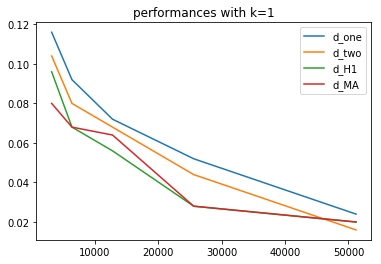

In [123]:
errors_k1 = errors[0]

for i in range(1,5):
    plot(Ns, errors_k1[i])
    
_ = title('performances with k=1')
_ = legend(['d_one','d_two','d_H1','d_MA'])

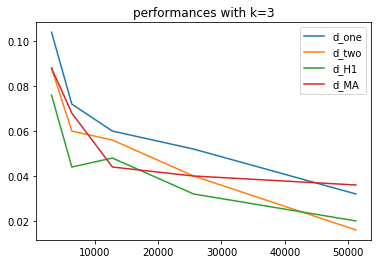

In [124]:
errors_k3 = errors[1]

for i in range(1,5):
    plot(Ns, errors_k3[i])
    
_ = title('performances with k=3')
_ = legend(['d_one','d_two','d_H1','d_MA'])


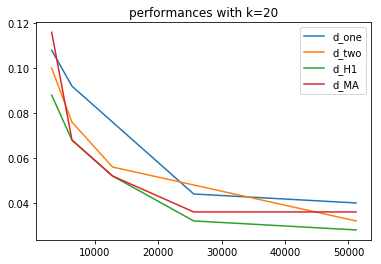

In [125]:
errors_k20 = errors[2]

for i in range(1,5):
    plot(Ns, errors_k20[i])
    
_ = title('performances with k=20')
_ = legend(['d_one','d_two','d_H1','d_MA'])

In [ ]:
""" It seems that increasing the number of neighbors doesn't improve the performances, I think this happens
    because these algorithms are better in finding two images that are almost perfectly identical 
    than measuring images similarity. So in my opinion these algorithms perform well because
    they have a large database in wich to find an almost identical image rather than
    because they are able to find some similar images and then they pick the most frequent. """

In [126]:
""" I noticed that effectively the ball tree didn't work well in terms of time, 
    so I tried to compare the performances for different leaf sizes.
    The leaf size parameter set when to switch to brute force when searcing for the nearest neighbor.
    It seems (on the web) that 40 (that is the default value) usually give the best results.
    
    What I expect is that building a tree with tiny leaves takes more time but reduce the searching time,
    and the opposite for large leaves. I also considered the limit case of a unique leaf, so in this case
    the searching algorithm should just compare the test image with every train image. """

print("building a ball tree with leaves of size 40 takes:")
%time tree_leaf_40 = build_ball_tree(60000,d_MA_ball_tree, leaf=40)

print("\nbuilding a ball tree with leaves of size 1000 takes:")
%time tree_leaf_1000 = build_ball_tree(60000,d_MA_ball_tree, leaf=1000)

print("\nbuilding a ball with just one leaf:")
%time tree_leaf_60000 = build_ball_tree(60000,d_MA_ball_tree, leaf=60000)

building a ball tree with leaves of size 40 takes:
CPU times: user 15.1 s, sys: 8 ms, total: 15.1 s
Wall time: 15.1 s

building a ball tree with leaves of size 1000 takes:
CPU times: user 10.3 s, sys: 4 µs, total: 10.3 s
Wall time: 10.3 s

building a ball with just one leaf:
CPU times: user 983 ms, sys: 0 ns, total: 983 ms
Wall time: 986 ms


In [127]:
""" As expected building a tree with small leaves takes more time, we can notice that building
    a tree with a unique leaf takes just almost 1 second.
    Now I try to compare the searching performance, and the trees with small leaf size should 
    perform better. I also compared it with a naive searching for the closest element in the training set. """

imm = [60123] # I take a random image in the test set

print("nearest neighbor searching time,\nleaf size 40:")
%time tree_leaf_40.query([imm], k=1)

print("\nleaf size 1000:")
%time tree_leaf_1000.query([imm], k=1)

print("\nleaf size 60000:")
%time tree_leaf_60000.query([imm], k=1)

print("\nnaive searching ")
%time _ = argmin([d_MA_ball_tree(imm,[i]) for i in range(60000)])

nearest neighbor searching time,
leaf size 40:
CPU times: user 1.01 s, sys: 1 µs, total: 1.01 s
Wall time: 1.01 s

leaf size 1000:
CPU times: user 1.04 s, sys: 0 ns, total: 1.04 s
Wall time: 1.04 s

leaf size 60000:
CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1.01 s

naive searching 
CPU times: user 962 ms, sys: 0 ns, total: 962 ms
Wall time: 962 ms


In [128]:
""" We can see that all the trees are probably looking for the nearest neighbor in a naive way,
    so they don't give an improvement to the naive way.
    I think that the problem is the high dimensionality, and that it's not possible to find "clusters"
    that well partition the space.
    So I tried to compare the performances of trees that deal with vectors with different dimensions. """

random.seed(0)
size = 60000

find_me = zeros(2)
X = np.random.random((60000, 2))  # 60000 points in 2 dimensions

tree_dim_2_leaf_40 = BallTree(X, leaf_size=40,  metric = 'pyfunc', func=d_two)
print("dimension=2, leaf=40:")
%time dist, ind = tree_dim_2_leaf_40.query([find_me], k=1)

tree_dim_2_leaf_60000 = BallTree(X, leaf_size=60000,  metric = 'pyfunc', func=d_two)
print("\ndimension=2, leaf=60000:")
%time dist, ind = tree_dim_2_leaf_60000.query([find_me], k=1)


find_me = zeros(28*28)
X = np.random.random((60000, 28*28))  # 60000 points in 28*28 dimensions

tree_dim_784_leaf_40 = BallTree(X, leaf_size=40,  metric = 'pyfunc', func=d_two)
print("\ndimension=784, leaf=40:")
%time dist, ind = tree_dim_784_leaf_40.query([find_me], k=1)

tree_dim_784_leaf_60000 = BallTree(X, leaf_size=60000,  metric = 'pyfunc', func=d_two)
print("\ndimension=784, leaf=60000:")
%time dist, ind = tree_dim_784_leaf_60000.query([find_me], k=1)


""" I also checked that the problem wasn't the user defined distance. """

find_me = zeros(2)
X = np.random.random((60000, 2))

tree_dim_2_leaf_40 = BallTree(X, leaf_size=40,  metric = 'euclidean')
print("\n\ndimension=2, leaf=40, predefined distance:")
%time dist, ind = tree_dim_2_leaf_40.query([find_me], k=1)

tree_dim_2_leaf_60000 = BallTree(X, leaf_size=60000,  metric = 'euclidean')
print("\ndimension=2, leaf=60000, predefined distance:")
%time dist, ind = tree_dim_2_leaf_60000.query([find_me], k=1)


find_me = zeros(28*28)
X = np.random.random((60000, 28*28))

tree_dim_784_leaf_40 = BallTree(X, leaf_size=40,  metric = 'euclidean')
print("\ndimension=784, leaf=40, predefined distance:")
%time dist, ind = tree_dim_784_leaf_40.query([find_me], k=1)

tree_dim_784_leaf_60000 = BallTree(X, leaf_size=60000,  metric = 'euclidean')
print("\ndimension=784, leaf=60000, predefined distance:")
%time dist, ind = tree_dim_784_leaf_60000.query([find_me], k=1)

dimension=2, leaf=40:
CPU times: user 0 ns, sys: 1.05 ms, total: 1.05 ms
Wall time: 829 µs

dimension=2, leaf=60000:
CPU times: user 275 ms, sys: 2 µs, total: 275 ms
Wall time: 274 ms

dimension=784, leaf=40:
CPU times: user 397 ms, sys: 0 ns, total: 397 ms
Wall time: 397 ms

dimension=784, leaf=60000:
CPU times: user 338 ms, sys: 0 ns, total: 338 ms
Wall time: 338 ms


dimension=2, leaf=40, predefined distance:
CPU times: user 147 µs, sys: 0 ns, total: 147 µs
Wall time: 140 µs

dimension=2, leaf=60000, predefined distance:
CPU times: user 912 µs, sys: 0 ns, total: 912 µs
Wall time: 551 µs

dimension=784, leaf=40, predefined distance:
CPU times: user 73.9 ms, sys: 0 ns, total: 73.9 ms
Wall time: 73.6 ms

dimension=784, leaf=60000, predefined distance:
CPU times: user 63.2 ms, sys: 3 µs, total: 63.2 ms
Wall time: 62.6 ms


In [130]:
""" So we can see that we obtained an improvement only in the case of low dimensionality. """